In [13]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt  
import seaborn as sns 
from IPython.display import Image
import imageio
from keras.utils.vis_utils import plot_model

from params_sys import *
from utils import *
from utils_sys import *
from utils_plot import *

from mobility_model import *        # Load the Gauss-Markov mobility model 
from channel_model import *         # Load the channel model (LoS+NLoS)
from traffic_model import *         # Load the traffic model 
from uav_controller import *        # Load the UAV movement controller class 

rng = np.random.default_rng()

%matplotlib inline

In [14]:
# To avoid: UserWarning: KMeans is known to have a memory leak on Windows with
# MKL, when there are less chunks than available threads. 
# You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

os.environ["OMP_NUM_THREADS"] = '1'

# SETUP

### User movement

In [15]:
#
# User movement: Gauss-Markov mobility model
#

fpath = os.path.join(sim_in_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, bound={boundary}.xlsx")

if os.path.exists(fpath)==False: 
    # Tracking positions of all users over time  
    xaxis_all = np.zeros(shape=(n_users, n_slots))          # x-axis 
    yaxis_all = np.zeros(shape=(n_users, n_slots))          # y-axis 

    # Gen user movements using the Gauss-Markov model 
    for id in range(n_users):
        x0 = rng.choice(initial_distance_range_x)
        y0 = rng.choice(initial_distance_range_y)
        
        xaxis_all[id], yaxis_all[id] = generate_mobility_GM(
            x0=x0, y0=y0, boundary=boundary, n_slots=n_slots, slot_len=slot_len, 
            upper_left=upper_left, lower_right=lower_right, speed_avg=speed_user_avg
        )
            
    # The centroid of all users over time 
    x_centroid = np.mean(xaxis_all, axis=0)
    y_centroid = np.mean(yaxis_all, axis=0)

    # Export to a xlsx file 
    to_excel(xaxis_all, os.path.join(sim_in_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, bound={boundary}.xlsx"))
    to_excel(yaxis_all, os.path.join(sim_in_path, f"ylocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, bound={boundary}.xlsx"))

    print(f'Exported data to {sim_in_path}')


### User traffic

In [16]:
fpath = os.path.join(sim_in_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx")

if os.path.exists(fpath)==False:
    arrival_traffic_Mb = np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)       # shape=(n_users,n_slots)
    ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)          # EMA of the arrival rate (Mbps)
    traffic_state = np.full(shape=(n_users, n_slots), fill_value=0, dtype=bool)
    traffic_type = np.full(shape=(n_users, n_slots), fill_value=-1, dtype=int)

    for uid in range(n_users): 
        traffic_state[uid,:], arrival_traffic_Mb[uid,:], traffic_type[uid,:] = \
            generate_traffic_ON_OFF(n_slots=n_slots, 
                                    ON_duration_mean_tslot = ON_duration_mean_tslot,
                                    OFF_duration_mean_tslot = OFF_duration_mean_tslot,
                                    data_arrival_mean_Mb = ON_data_arrival_mean_Mb)

    ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
    for t in range(1,n_slots): 
        ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]
        
    lambd_Mb_alluser = np.mean(arrival_traffic_Mb, axis=1)        # shape=(n_users)
    
    # Export to a xlsx file 
    to_excel(arrival_traffic_Mb, os.path.join(sim_in_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
    to_excel(traffic_state, os.path.join(sim_in_path,f"traffic state, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
    to_excel(traffic_type, os.path.join(sim_in_path,f"traffic type, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))

    print(f'Gnerated new input data for simulation in {sim_in_path}')
else:
    print("Input data for simulation exists!")

Input data for simulation exists!


### Load user data

In [17]:
import pandas as pd 
from copy import deepcopy

def from_exel(fname):
    x = pd.read_excel(fname, index_col=0).to_numpy()
    y = np.transpose(x)
    return y
    
sim_in_path = os.path.join(os.getcwd(), 'simulation', 'sim-input')

### Load user location 
xaxis_all = from_exel(os.path.join(sim_in_path, f"xlocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, bound={boundary}.xlsx"))
yaxis_all = from_exel(os.path.join(sim_in_path, f"ylocation, nusers={n_users}, nslots={n_slots}, speed_avg={speed_user_avg:.1f}, bound={boundary}.xlsx"))
x_centroid = np.mean(xaxis_all, axis=0)
y_centroid = np.mean(yaxis_all, axis=0)

### Load user traffic 
arrival_traffic_Mb = from_exel(os.path.join(sim_in_path, f"arrival traffic, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
traffic_state = from_exel(os.path.join(sim_in_path,f"traffic state, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
traffic_type = from_exel(os.path.join(sim_in_path,f"traffic type, nusers={n_users}, nslots={n_slots}, lambda_Mb={lambd_Mb:.1f}, uON={ON_duration_mean_tslot:.0f}, uOFF={OFF_duration_mean_tslot:.0f}.xlsx"))
ema_traffic_Mb =  np.full(shape=(n_users, n_slots), fill_value=0, dtype=float)          # EMA of the arrival rate (Mbps)
ema_traffic_Mb[:, 0] = alpha_ema*arrival_traffic_Mb[:,0]
for t in range(1,n_slots): 
    ema_traffic_Mb[:, t] = alpha_ema*arrival_traffic_Mb[:,t] + (1-alpha_ema)*ema_traffic_Mb[:,t-1]
lambd_Mb_alluser = np.mean(arrival_traffic_Mb, axis=1)        # shape=(n_users)

print('Loaded user data from excel files')

Loaded user data from excel files


In [18]:
print('Mean Traffic of one user (expected): \t{x:.2f} Mb/slot'.format(x=np.mean(ON_data_arrival_mean_Mb)*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot)) )
print('Mean Traffic of one user (generated): \t{x:.2f} Mb/slot'.format(x=np.mean(arrival_traffic_Mb)) )
print('Arrival Rate in ON-state (generated): \t{x:.2f} Mb/slot'.format(x=np.sum(arrival_traffic_Mb)/np.sum(traffic_state)))

Mean Traffic of one user (expected): 	2.00 Mb/slot
Mean Traffic of one user (generated): 	1.83 Mb/slot
Arrival Rate in ON-state (generated): 	1.84 Mb/slot


### Visualize user data

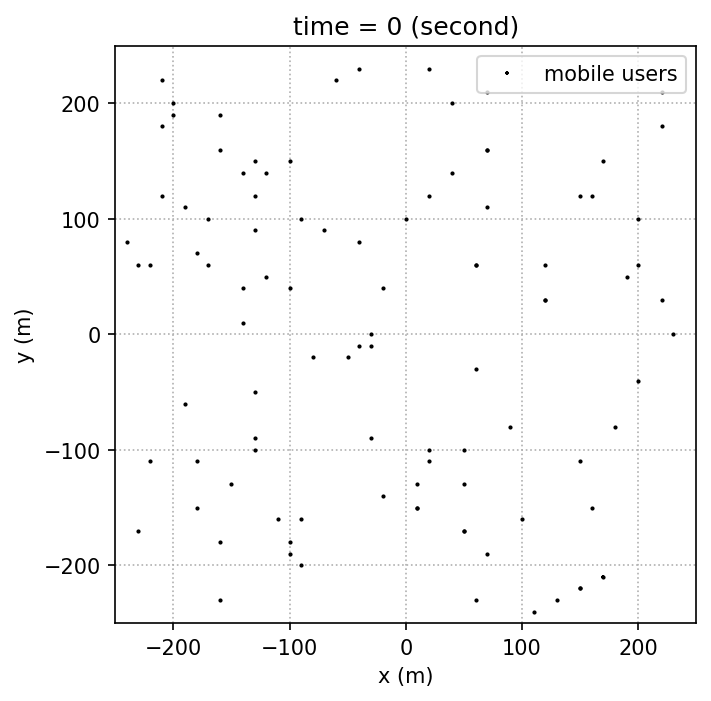

In [19]:
''' Animation of user locations '''

gif_path = gen_animation_user_locations(
    xaxis_all=xaxis_all, yaxis_all=yaxis_all, t_max = 100, t_step = 10, folder_name = 'simulation/png2gif'
)
Image(filename=gif_path, width=350)


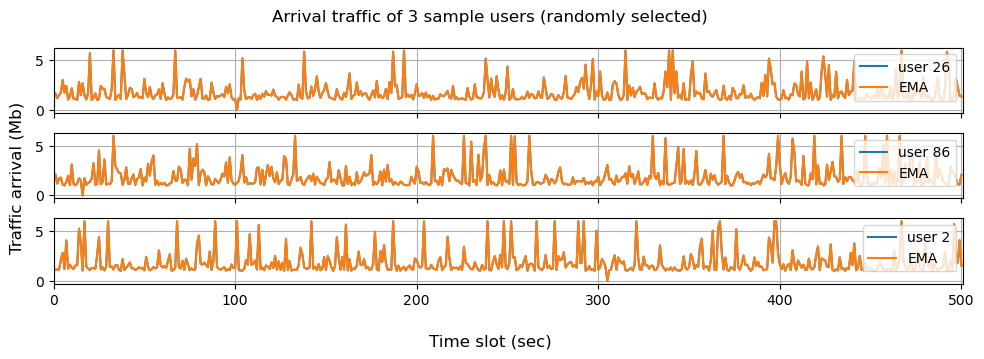

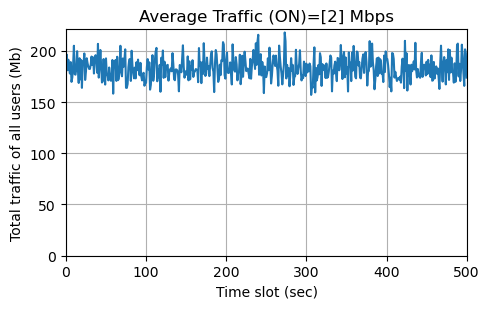

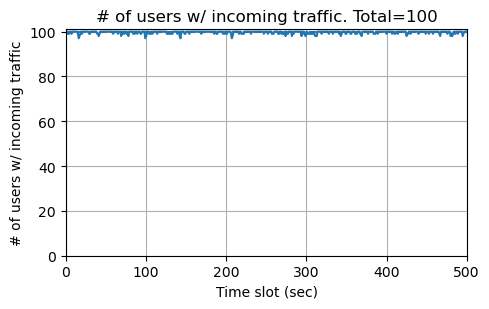

In [20]:
'''Arrival traffic of some sample users'''

n_samples = 3
sample_ids = np.random.choice(n_users, size=(n_samples), replace=False) # randomly select some users for plotting 
fig, axes = plt.subplots(n_samples,1, figsize=(10, 3.5), sharex=True, sharey=True)
for i, axis in enumerate(axes):
    axis.plot(arrival_traffic_Mb[sample_ids[i]], label=f'user {sample_ids[i]}')
    axis.plot(ema_traffic_Mb[sample_ids[i]], label='EMA')
    axis.grid(True)
    axis.legend(loc='upper right')
    axis.set(xlim=[0, n_slots])    
fig.suptitle(f"Arrival traffic of {n_samples} sample users (randomly selected)")
fig.supxlabel('Time slot (sec)')
fig.supylabel('Traffic arrival (Mb)')
fig.tight_layout()
plt.savefig(os.path.join(sim_out_path,"incoming_traffic_of_sample_users_over_time.png"), bbox_inches='tight')
plt.show()


"""Total incoming traffic of all users """
traffic_sum_Mb = np.sum(arrival_traffic_Mb, axis=0)
fig, ax = plt.subplots(figsize=(5,3.2)) 
plt.plot(traffic_sum_Mb)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='Total traffic of all users (Mb)', 
       title=f'Average Traffic (ON)={ON_data_arrival_mean_Mb} Mbps',
       xlim=[0, n_slots])
plt.ylim(bottom=0)
fig.tight_layout()
plt.savefig(os.path.join(sim_out_path,"traffic-total-all-users.png"), bbox_inches='tight')
plt.show()


'''Number of users with incoming traffic''' 
traffic_state_sum = np.sum(traffic_state, axis=0)
fig, ax = plt.subplots(figsize=(5,3.2)) 
plt.plot(traffic_state_sum)
plt.grid(True)
ax.set(xlabel='Time slot (sec)', ylabel='# of users w/ incoming traffic', 
       title=f'# of users w/ incoming traffic. Total={n_users}',
       xlim=[0, n_slots], ylim=[0,n_users+1])
plt.axhline(y=n_users*ON_duration_mean_tslot/(ON_duration_mean_tslot+OFF_duration_mean_tslot), linestyle='--')
fig.tight_layout()
plt.savefig(os.path.join(sim_out_path,"traffic-n_actives.png"), bbox_inches='tight')
plt.show()


### Channel model

In [21]:
n_points = 100
zmax, zmin = z_max, z_min
xuav, yuav = 0, 0
xaxis = np.linspace(0, boundary, n_points)
yaxis = np.zeros(n_points)
alpha = 1

print(f"bw per user = {bw_per_user / 1e6:.1f} MHz")

bw per user = 0.3 MHz


In [22]:
def cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav, n_points=n_points):
    '''Calculate the downlink throughput w.r.t. the relative position of users'''
    chgain = np.zeros(n_points)
    chcapa_Mb = np.zeros(n_points)
    chcapa_bpsHz = np.zeros(n_points)
    for i in range(0,n_points):
        chgain[i] = cal_channel_fading_gain(xaxis[i], yaxis[i], xuav, yuav, zuav)
        chcapa_Mb[i], chcapa_bpsHz[i] = cal_channel_capacity_Mb(chgain[i], alpha)
    return chcapa_Mb, chcapa_bpsHz

In [23]:
def cal_capacity_xyuser(xuser, yuser, zuav_vec):
    chgain = np.zeros(n_points)
    chcapa_Mb = np.zeros(n_points)
    chcapa_bpsHz = np.zeros(n_points)
    for i in range(0,n_points):
        chgain[i] = cal_channel_fading_gain(xuser, yuser, xuav, yuav, zuav_vec[i])
        chcapa_Mb[i], chcapa_bpsHz[i] = cal_channel_capacity_Mb(chgain[i], alpha)
    
    return chcapa_Mb, chcapa_bpsHz

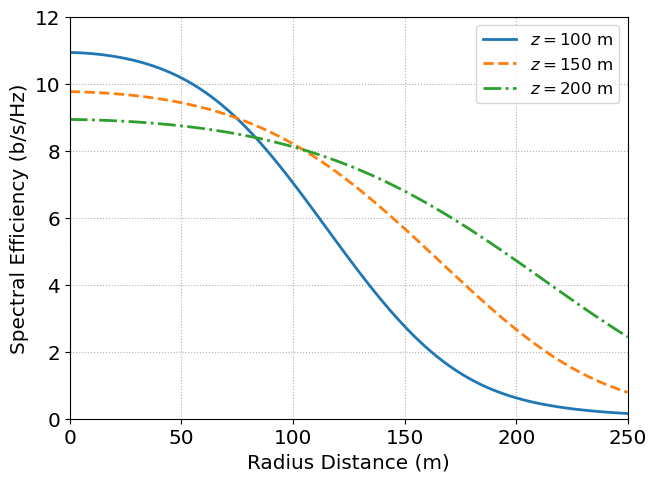

In [ ]:
# Spectral Efficiency (bps/Hz) vs Radius Distance

zuav_list = [100, 150, 200]
linestyles = ["-", "--", "-."]
radius_dist = np.sqrt((xaxis - xuav)**2 + (yaxis - yuav)**2)

fig, ax = plt.subplots()
for i, zuav in enumerate(zuav_list):
    ax.plot(
        radius_dist, cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav)[1],
        label=f'$z = {zuav:.0f}$ m', linestyle=linestyles[i], linewidth=2
    )
plt.xlabel('Radius Distance (m)', fontsize='x-large')
plt.ylabel('Spectral Efficiency (b/s/Hz)', fontsize='x-large')
plt.tight_layout()
plt.grid(True, linestyle=":")
plt.legend(fancybox=True, fontsize="large")
plt.ylim(bottom=0, top=np.ceil(plt.ylim()[1]))
plt.xlim(left=radius_dist[0], right=radius_dist[-1])
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.savefig(
    os.path.join(sim_out_path, 'spactral-efficiency-vs-radius-distance.pdf'),
    bbox_inches='tight'
)
plt.show()

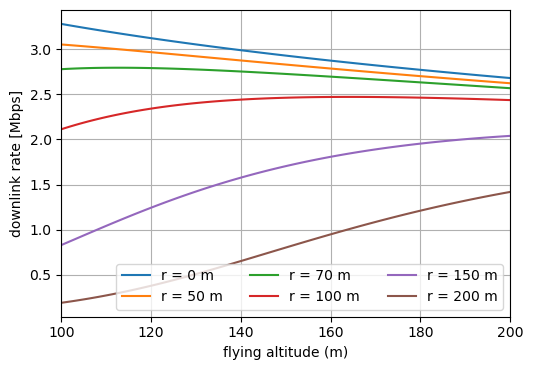

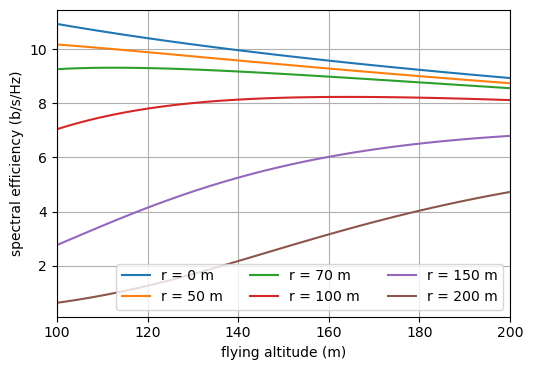

In [ ]:
ulocs = [(0,0), (50,0), (70,0), (100,0), (150,0), (200,0)]
zuav_vec = np.linspace(zmin, zmax, n_points)

#
# Donwlink Rate (Mbps) w.r.t. Flying Altitude (m)
#
fig, ax = plt.subplots(figsize=(5,3.5))
for uloc in ulocs: 
    ax.plot(
        zuav_vec, cal_capacity_xyuser(uloc[0], uloc[1], zuav_vec)[0],
        label=f'r = {np.sqrt(uloc[0]**2+uloc[1]**2):.0f} m'
    )
ax.set(xlabel='flying altitude (m)', ylabel='downlink rate [Mbps]')
plt.tight_layout(pad=0)
plt.grid(True)
plt.xlim(left=zuav_vec[0], right=zuav_vec[-1])
plt.legend(ncol=3)
plt.savefig(os.path.join(sim_out_path, 'channel-capa-vs-flying-altitude.png'), bbox_inches='tight')
plt.show()


#
# Spectral Efficiency (bps/Hz) w.r.t. Flying Altitude (m)
#
fig, ax = plt.subplots(figsize=(5,3.5))
for uloc in ulocs: 
    ax.plot(
        zuav_vec, cal_capacity_xyuser(uloc[0], uloc[1], zuav_vec)[1],
        label=f'r = {np.sqrt(uloc[0]**2+uloc[1]**2):.0f} m'
    )
ax.set(xlabel='flying altitude (m)', ylabel='spectral efficiency (b/s/Hz)')
plt.tight_layout(pad=0)
plt.grid(True)
plt.xlim(left=zuav_vec[0], right=zuav_vec[-1])
plt.legend(ncol=3)
plt.savefig(os.path.join(sim_out_path, 'spactral-efficiency-vs-flying-altitude.png'), bbox_inches='tight')
plt.show()

In [27]:
#
# Export channel model data to excel file
#

d_dict = {'radius distance (m)': radius_dist}
for zuav in zuav_list: 
    d_dict[f'z={zuav}'] = cal_capacity_zuav(xaxis, yaxis, xuav, yuav, zuav)[0]
df = pd.DataFrame(d_dict)
df.to_excel(os.path.join(sim_out_path,'channel-capacity-Mbps.xlsx'))
print(f'Exported to {sim_out_path}')

Exported to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10


# SIMULATION
- The UAVs and users move round within the target zone 
- The channel condition fluctuates due to user movement
- Queue evolves depending on the arrival traffic and downlink rate

### Stationary

In [28]:
# Initiate the UAV Swarm 
uavswarm_stationary = [UAV(name= f'UAV {i} (Stationary)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=0, speedz_max=0) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_stationary = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_stationary, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# Alias for ease of code maintenance 
uavs = uavswarm_stationary
users = users_stationary          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)    # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0 
    mos_all = np.array([user.mos[t-1] for user in users]) if t > 0 else 5 * np.ones(n_users)

    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1),
                           np.expand_dims(yaxis_all[:,t], axis=1),
                           np.zeros(shape=(n_users,1))))                    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    if t==0:  # clustering at t=0 
        cids0 = cids.copy()
    
    # # (2) Bandwidth allocation based on the traffic demand 
    # alpha_uavs = np.zeros(shape=(n_uavs, n_users))      # shape=(n_uavs, n_users)
    # for cid, uav in enumerate(uavs):   
    #     mask = isActive_all & (cids==cid)               # users that are active and belong to the considered cluster, shape=(n_users,) 
    #     alpha_uavs[cid] = allocate_bandwidth_based_on_demand(queue_length_Mb+traffic_Mb, mask)
    # assert np.all(np.sum(alpha_uavs>0, axis=0) <= 1), "Each user should be associated to exactly one UAV-BS"
    # bw_alloc_all = np.sum(alpha_uavs, axis=0)              # shape=(n_users,)
    
    # # (2) Bandwidth Allocation: allocate equally among active users (qlen + new traffic > 0) 
    # bw_alloc_all = allocate_bandwidth_equal_to_active_users(isActive_all)
    
    # (2) Bandwidth Allocation
    bw_alloc_all = allocate_bandwidth_limited(
        mos=mos_all, cids=cids, n_channels=n_channels, n_uavs=n_uavs
    )
    
    # (3) UAV Updates: Keep stationary at the first location 
    # for uav in uavs: 
    #     uav.x[t], uav.y[t], uav.z[t] = uav.x[0], uav.y[0], uav.z[0] 
        
    # (3) UAV Updates: Move toward the initial centroids (of t=0) 
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                dx, dy, dd, uav_speed = 0, 0, 0, 0  # no movement 
            else: 
                xc0, yc0 = np.mean(xaxis_all[cids0==cid, 0]), np.mean(yaxis_all[cids0==cid, 0])   
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc0, yc0)
                # uav_speed = np.min([dd/(uav.speedxy_max*slot_len), 1])*uav.speedxy_max      # greedily move toward the centroid w/ vmax 
                uav_speed = np.min([dd/(uav_vxy_fixed*slot_len), 1])*uav_vxy_fixed
            
            uav.x[t], uav.y[t] = update_UAV_location(
                x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len
            )
            uav.z[t] = uav.z[0]
            uav.velocity[t] = uav_speed
            uav.pw_prop_W[t] = cal_uav_propulsion_energy(V=uav_speed)[0]
        
    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]; cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]               
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 
        user.delay[t] = d0 + user.ema_qlen_Mb[t] / user.lambd_Mb

t=0
t=100
t=200
t=300
t=400
t=500


### Centroid

In [29]:
# Initiate the UAV Swarm 
uav_swarm_centroid = [UAV(name= f'UAV {i} (Centroid)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_centroid = [User(f'User {i}') for i in range(n_users)]
load_user_properties(users_centroid, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state, traffic_type, ema_traffic_Mb, lambd_Mb_alluser)

# Alias for ease of code maintenance 
uavs = uav_swarm_centroid
users = users_centroid          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    mos_all = np.array([user.mos[t-1] for user in users]) if t > 0 else 5 * np.ones(n_users)

    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) Bandwidth Allocation
    bw_alloc_all = allocate_bandwidth_limited(
        mos=mos_all, cids=cids, n_channels=n_channels, n_uavs=n_uavs
    )
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                dx, dy, dd, uav_speed = 0, 0, 0, 0  # no movement 
            else: 
                xc, yc = np.mean(xaxis_all[cids==cid, t]), np.mean(yaxis_all[cids==cid, t])   # centroid of the cluster 
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], xc, yc)
                uav_speed = np.min([dd/(uav_vxy_fixed * slot_len), 1]) * uav_vxy_fixed 

            uav.x[t], uav.y[t] = update_UAV_location(x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len)
            uav.z[t] = uav.z[0]
            uav.velocity[t] = uav_speed
            uav.pw_prop_W[t] = cal_uav_propulsion_energy(V=uav_speed)[0]


    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 
        user.delay[t] = d0 + user.ema_qlen_Mb[t] / user.lambd_Mb


t=0
t=100
t=200
t=300
t=400
t=500


### Proposed

In [30]:
# Initiate the UAV Swarm 
uav_swarm_proposed = [UAV(name= f'UAV {i} (Proposed)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init_proposed, 
                        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max) for i in range(0,n_uavs)]

# UAV's flight controller 
uav_controller = UAV_Movement_Controller(
    boundary=boundary, grid_size=grid_size, uav_speedxy_max=uav_speedxy_max,
    n_decisions=n_decisions, n_uavs=n_uavs, zmin=z_min, zmax=z_max,
    uav_speedz_max=uav_speedz_max, std_var_vxvyvz_explore=std_var_vxvyvz_explore,
    std_var_vxvyvz_exploit=std_var_vxvyvz_exploit
)
uav_controller.cal_channel_fading_gain = cal_channel_fading_gain
uav_controller.cal_channel_capacity_Mb = cal_channel_capacity_Mb
uav_controller.Vlya = lyapunov_param
uav_controller.gen_heatmap = gen_heatmap
uav_controller.mos_func = mos_func

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_proposed = [User(f'User {i}') for i in range(n_users)]
load_user_properties(
    users_proposed,
    xaxis_all, yaxis_all,                               # location
    arrival_traffic_Mb, traffic_state, traffic_type,    # traffic
    ema_traffic_Mb, lambd_Mb_alluser
)

# Alias for ease of code maintenance 
uavs = uav_swarm_proposed
users = users_proposed          
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t > 0 else np.zeros(n_users)  # (n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    capacity_Mb = np.array([user.channel_capacity_Mb[t-1] for user in users]) if t > 0 else np.zeros(n_users)     # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # (n_users,), True if qlen + traffic > 0
    traffic_state_all = np.array([user.traffic_state[t] for user in users])     # shape=(n_users,)
    mos_all = np.array([user.mos[t-1] for user in users]) if t > 0 else 5 * np.ones(n_users)
    ld_Mbps = np.array([0 if (user.traffic_type[t] == -1) else ON_data_arrival_mean_Mb[user.traffic_type[t]] for user in users])
    
    # (1) User Clustering: based on locations of users 
    loc_users = np.hstack((
        np.expand_dims(xaxis_all[:,t], axis=1),
        np.expand_dims(yaxis_all[:,t], axis=1),
        np.zeros(shape=(n_users,1))
    ))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs)        # cluster matrix, ids, and centroid
    
    # (2) Bandwidth Allocation
    bw_alloc_all = allocate_bandwidth_limited(
        mos=mos_all, cids=cids, n_channels=n_channels, n_uavs=n_uavs
    )
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            uav_location = (uav.x[t-1], uav.y[t-1], uav.z[t-1])  
            user_locations = (xaxis_all[:,t], yaxis_all[:,t])    # a tupple of 2 arrays of shape (n_users,)
            mask = (cids==cid) & traffic_state_all       # True if an user belongs to the cluster and is active (i.e., qlen + traffic > 0)
            
            # (3.0) Collect user statistics
            # Only users belonging to the considered cluster are counted  
            # Random noise-added to avoid gradient vanishing 
            user_count_masked = np.ones(n_users)*mask  # shape = (n_users,)
            queue_length_Mb_masked = queue_length_Mb*mask  # shape=(n_users)
            incoming_traffic_Mb_masked = traffic_Mb*mask      # shape = (n_users,)
            downlink_load_masked =  queue_length_Mb_masked + incoming_traffic_Mb_masked  # shape = (n_users,)
            ch_capacity_Mb_masked = capacity_Mb*mask    # shape = (n_users,)
            user_statistics = (
                downlink_load_masked,
                queue_length_Mb_masked,
                incoming_traffic_Mb_masked,
                ld_Mbps
            )
            normalization_coeff = (queue_norm_Mb,)      # user_counter_norm 
            
            # (3.1) Make a movement decision (dx, dy, and uav_speed) and (3.2) Update the replay memory
            if t >= t_training_start:
                dnn_prediction, best_decision = \
                    uav_controller.make_movement_decision(
                        uav_location,user_locations, user_statistics,
                        normalization_coeff, mask, bw_alloc_all,
                        vqlen_prop=uav.vqlen_prop[t-1]
                    )
                dx, dy, vxy, dz, vz = best_decision         # dx and dy: -1 to 1, uav_speedxy: 0 to uav_speed_max, uav_speedz: -1 to 1 
            else: 
                # make no movement, do not update the replay memory 
                dx, dy, vxy, dz, vz = 0, 0, 0, 0, 0         
            
            # (3.3) Update the UAV location 
            xt, yt = update_UAV_location(
                x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=vxy, slot_len=slot_len
            )
            uav.x[t] = adjust_location(xt, bound=boundary)
            uav.y[t] = adjust_location(yt, bound=boundary)
            zt = update_UAV_altitude(z0=uav.z[t-1], dz=dz, vz=vz, slot_len=slot_len)
            uav.z[t] = adjust_altitude(zt, zmin=z_min, zmax=z_max)
            velocity = np.sqrt(vxy**2 + vz**2)
            uav.velocity[t] = velocity
            uav.pw_prop_W[t] = cal_uav_propulsion_energy(V=velocity)[0]
            uav.vqlen_prop[t] = update_vqlen_prop(uav.vqlen_prop[t-1], uav.pw_prop_W[t])
            
        # (3.4) Retrain the DNN periodically 
        if (uav_controller.memory_counter_train >= uav_controller.min_samples_for_training) \
            and (t >= t_training_start) \
            and (t % training_interval==0):   # (uav_controller.memory_counter_train % uav_controller.training_interval == 0)\
            uav_controller.retrain_dnn()
    
    # (4) User Updates
    for id, user in enumerate(users):
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]

        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_=user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan
        user.delay[t] = d0 + user.ema_qlen_Mb[t] / user.lambd_Mb


t=0
t=100
t=200
t=300
t=400
t=500


### K-means + A2C agent

In [31]:
import torch
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

from gym_env.envs.sagin_v1 import SingleDroneEnv_ContinuousSpace
from gym_env.envs.utils import get_obs_flattened, save_img_from_rgba_arr

In [32]:
# Initiate the environment
env = SingleDroneEnv_ContinuousSpace(
    fading=True,
    seed=None,
    uav_init_mode='specific',
    uav_init_locs=np.array([250, 250]).reshape(2, -1),
    stddev=50,
    n_users=25
)
check_env(env)

# Load the A2C agent
model = A2C(
    policy="MlpPolicy",
    env=env,
    learning_rate = 1e-4,
    tensorboard_log = "sarl/runs",
    device = "cuda",
    policy_kwargs = {
        "activation_fn": torch.nn.ReLU,
        "net_arch": dict(
            vf=[256, 256],
            pi=[256, 256]
        ),  # "net_arch": [256, 256],
    },
)

model = A2C.load("gym_env/sarl/trained_agents/stable/A2C_512k")
deterministic = True


c:\Users\linhh\anaconda3\envs\tf-gpu-env\lib\site-packages\stable_baselines3\common\env_checker.py:464: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


Terminated with 512/512 steps
UAV's final position: [0.66167993 0.11935716]
Image saved to c:\Users\linhh\OneDrive\Documents\Git\j2-uavbs-placement-drl-dev\gym_env/sarl/images/observation.png


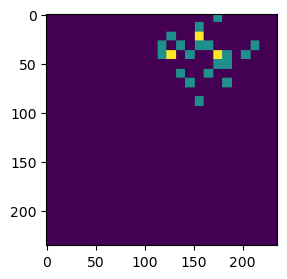

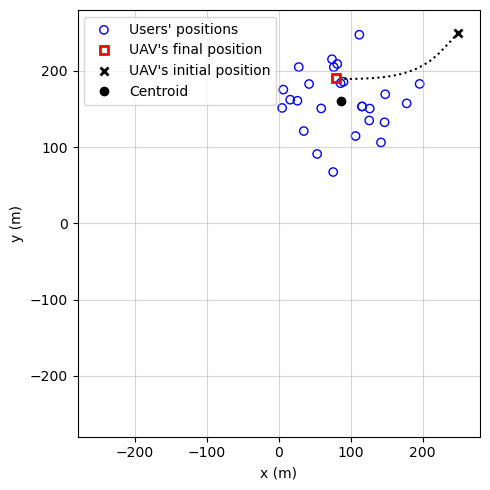

In [33]:
#
# RUN AN EPISODE
#

observation, info = env.reset(seed=None)
log_uav_locs = env.locs['self']
while True:
        # action = env.action_space.sample()  # agent policy that uses the observation and info
        action, _states = model.predict(observation, deterministic=deterministic)
        # observation, reward, terminated, truncated, info = env.step(action.item())
        observation, reward, terminated, truncated, info = env.step(action)
        log_uav_locs = np.append(log_uav_locs, env.locs['self'], axis=1)

        if terminated or truncated:
                break

print(f"Terminated with {1 + env.n_steps}/{env.max_cycles} steps")


""" PLOTTING: OBSERVATIONS OF THE AGENT """
ob_last = observation.copy()
print(f"UAV's final position: {ob_last[:2]}")
hm = ob_last[2:].reshape(25, -1)
save_img_from_rgba_arr(hm, transparent=False, fpath="gym_env/sarl/images/observation.png")

fig, ax = plt.subplots(figsize=(3,3))
im = plt.imread("gym_env/sarl/images/observation.png")
ax.imshow(im)
plt.show()


""" PLOTTING: TRAJECTORY """
log_uav_locs = np.array(log_uav_locs)
x_drone = log_uav_locs[0]
y_drone = log_uav_locs[1]
x_users = env.locs['user'][0]
y_users = env.locs['user'][1]
bound = env.bound

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_users, y_users, marker='o', facecolors='none', edgecolors='b')
ax.scatter(x_users[-1], y_users[-1], marker='o', facecolors='none', 
           edgecolors='b', label="Users' positions"
)
ax.plot(x_drone, y_drone, ":", color="k")
ax.plot(x_drone[-1], y_drone[-1], marker='s', markerfacecolor='none',
        markeredgecolor = 'r', markeredgewidth=2, linestyle='none',
        label="UAV's final position"
)
ax.plot(x_drone[0], y_drone[0], marker='x', color='k', markeredgewidth=2,
        linestyle='none', label="UAV's initial position"
)
ax.plot(np.mean(x_users), np.mean(y_users), 'ok', label="Centroid")

plt.xlim(-bound - 30, bound + 30)
plt.ylim(-bound - 30, bound + 30)
plt.grid(True, alpha=0.5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.tight_layout()

plt.savefig(fname='gym_env/sarl/images/trajectory.png')
plt.show()

In [34]:
#
# SIMULATION
#


# Initiate the UAV Swarm 
uav_swarm_a2c = [
    UAV(
        name= f'UAV {i} (A2C)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
        xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max
    ) for i in range(0,n_uavs)
]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_a2c = [User(f'User {i}') for i in range(n_users)]
load_user_properties(
    users_a2c, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state,
    traffic_type, ema_traffic_Mb, lambd_Mb_alluser
)

# Alias for ease of code maintenance 
uavs = uav_swarm_a2c
users = users_a2c
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    mos_all = np.array([user.mos[t-1] for user in users]) if t > 0 else 5 * np.ones(n_users)

    # (1) User Clustering 
    loc_users = np.hstack((np.expand_dims(xaxis_all[:,t], axis=1), np.expand_dims(yaxis_all[:,t], axis=1), np.zeros(shape=(n_users,1))))    # shape = (n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
                else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape = (n_uavs, 3)
    cmat, cids, c_centroids = kmeans_clustering(loc_users, loc_uavs, n_clusters=n_uavs)
    
    # (2) Bandwidth Allocation
    bw_alloc_all = allocate_bandwidth_limited(
        mos=mos_all, cids=cids, n_channels=n_channels, n_uavs=n_uavs
    )
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                vx, vy = 0, 0  # no movement 
            else:
                xlocs = xaxis_all[cids==cid, t]
                ylocs = yaxis_all[cids==cid, t]
                observation = get_obs_flattened(
                    locs={
                        'self': np.asarray([uav.x[t-1], uav.y[t-1]]).reshape(2, 1),
                        'user': np.asarray([xlocs, ylocs])
                    },
                    bound=boundary,
                    grid_size=grid_size,
                    grid_norm=user_counter_norm,
                    mode="sarl"
                )
                action, _states = model.predict(observation, deterministic=deterministic)
                vx = action[0] * uav_vxy_a2c
                vy = action[1] * uav_vxy_a2c

            uav.x[t] = uav.x[t-1] + vx * slot_len
            uav.y[t] = uav.y[t-1] + vy * slot_len
            uav.z[t] = uav.z[0]
            uav.velocity[t] = np.sqrt(vx**2 + vy**2)
            uav.pw_prop_W[t] = cal_uav_propulsion_energy(V=uav.velocity[t])[0]


    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 
        user.delay[t] = d0 + user.ema_qlen_Mb[t] / user.lambd_Mb


t=0
t=100
t=200
t=300
t=400
t=500


### Majority vote

In [35]:
# Initiate the UAV Swarm 
uav_swarm_majority = [
    UAV(name= f'UAV {i} (Majority)', x_init=init_locations_uav[i][0], y_init=init_locations_uav[i][1], z_init=z_init, 
    xlim = xlim_uav[i], ylim = ylim_uav[i], speedxy_max=uav_speedxy_max, speedz_max=uav_speedz_max
    ) for i in range(0,n_uavs)
]

# Initiate users of the Stationary UAV Swarm with movements and traffic 
users_majority = [User(f'User {i}') for i in range(n_users)]
load_user_properties(
    users_majority, xaxis_all, yaxis_all, arrival_traffic_Mb, traffic_state,
    traffic_type, ema_traffic_Mb, lambd_Mb_alluser
)

# Alias for ease of code maintenance 
uavs = uav_swarm_majority
users = users_majority
    
# Simulation starts!  
for t in range(0, n_slots):         # t = timeslot
    if t%100==0: 
        print(f"t={t}")
    # (0) Collect system statistics 
    queue_length_Mb = np.array([user.queue_length_Mb[t-1] for user in users]) if t>0 else np.zeros(n_users)     # shape=(n_users,)
    traffic_Mb = np.array([user.arrival_traffic_Mb[t] for user in users])       # shape=(n_users,)
    isActive_all = find_active_users(queue_len_Mb=queue_length_Mb, incoming_traffic_Mb=traffic_Mb)  # shape=(n_users,), =1 if qlen + traffic > 0
    mos_all = np.array([user.mos[t-1] for user in users]) if t > 0 else 5 * np.ones(n_users)

    # (1) User Clustering 
    loc_users = np.hstack((
        np.expand_dims(xaxis_all[:, t], axis=1),
        np.expand_dims(yaxis_all[:, t], axis=1),
        np.zeros(shape=(n_users, 1))
    ))    # shape=(n_users, 3)
    loc_uavs = np.array([[uav.x[t-1], uav.y[t-1], uav.z[t-1]] for uav in uavs]) if t>0 \
        else  np.array([[uav.x[0], uav.y[0], uav.z[0]] for uav in uavs])  # shape=(n_uavs, 3)
    cids = zone_clustering(loc_users=loc_users, loc_uavs=loc_uavs)
    
    # (2) Bandwidth Allocation
    bw_alloc_all = allocate_bandwidth_limited(
        mos=mos_all, cids=cids, n_channels=n_channels, n_uavs=n_uavs
    )
    
    # (3) UAV Updates: Movement and Energy Consumption  
    if t > 0: 
        for cid, uav in enumerate(uavs):        # cid = cluster id 
            if t < t_training_start: 
                dx, dy, dd, uav_speed = 0, 0, 0, 0  # no movement 
            else: 
                xc, yc = np.mean(xaxis_all[cids==cid, t]), np.mean(yaxis_all[cids==cid, t])   # cluster centroid
                x_opt, y_opt = get_majorvote_placement(
                    zoneid=cid,
                    xlocs=xaxis_all[cids==cid, t],
                    ylocs=yaxis_all[cids==cid, t],
                    boundary=boundary, beta=beta_majority
                )
                dx, dy, dd = cal_direction(uav.x[t-1], uav.y[t-1], x_opt, y_opt)
                uav_speed = np.min([dd/(uav_vxy_fixed * slot_len), 1]) * uav_vxy_fixed 

            uav.x[t], uav.y[t] = update_UAV_location(
                x0=uav.x[t-1], y0=uav.y[t-1], dx=dx, dy=dy, speed=uav_speed, slot_len=slot_len
            )
            uav.z[t] = uav.z[0]
            uav.velocity[t] = uav_speed
            uav.pw_prop_W[t] = cal_uav_propulsion_energy(V=uav_speed)[0]


    # (4) User Updates  
    for id, user in enumerate(users): 
        user.cluster[t] = cids[id]
        cid = cids[id]      # id of the user's cluster  
        user.active_state[t] = isActive_all[id]
        user.alpha[t] = bw_alloc_all[id]       # fixed bandwidth for each user 
        user.chgains_downlink[t] = cal_channel_fading_gain(user.x[t], user.y[t], uavs[cid].x[t], uavs[cid].y[t], uavs[cid].z[t])
        user.channel_capacity_Mb[t] = cal_channel_capacity_Mb(user.chgains_downlink[t], user.alpha[t])[0]
        
        qlen_prev_Mb = user.queue_length_Mb[t-1] if t > 0 else 0
        user.queue_length_Mb[t] = update_queue_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t]) 
        user.downlink_throughput_Mb[t] = cal_downlink_throughput_Mb(qlen_prev_Mb, user.arrival_traffic_Mb[t], user.channel_capacity_Mb[t])
        user.ema_qlen_Mb[t] = alpha_ema*user.queue_length_Mb[t] + (1-alpha_ema)*user.ema_qlen_Mb[t-1]
        user.mos[t] = mos_func(qlen=user.ema_qlen_Mb[t], lambda_= user.lambd_Mb) if (user.traffic_state[t]==True) else np.nan 
        user.delay[t] = d0 + user.ema_qlen_Mb[t] / user.lambd_Mb


t=0
t=100
t=200
t=300
t=400
t=500


# PERFORMANCE EVALUATION


In [36]:
users_list = [users_stationary, users_centroid, users_majority,  users_a2c, users_proposed]
uavs_list = [uavswarm_stationary, uav_swarm_centroid, uav_swarm_majority, uav_swarm_a2c, uav_swarm_proposed] 
names = ['Stationary', 'Centroid-based', 'Majority-based', 'DQL-based', 'LyDRL (Proposed)']

xlim_tmax = n_slots + 1


### Channel Capacity

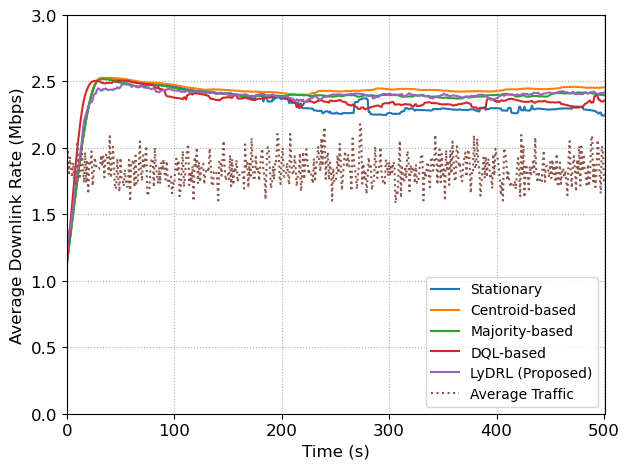

In [37]:
rolling_interval = 1
tvec = np.arange(0,n_slots)
xlim_tmax = n_slots
t_step = 1                      # for the moving average of KPI 
dict_kpi = {}

fig, ax = plt.subplots()
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    kpi_all = np.array([user.channel_capacity_Mb for user in users])
    kpi_avg = np.mean(kpi_all, axis=0)
    kpi_mmean = export_moving_average(kpi_avg, rolling_interval)      
    plt.plot(tvec[::t_step], kpi_mmean[::t_step], '-', markerfacecolor='None', label=fname)
    dict_kpi[names[i]+' (avg)'] = np.mean(kpi_all, axis=0) 
    dict_kpi[names[i]+' (sum)'] = np.sum(kpi_all, axis=0) 

traffic_mmean = export_moving_average(traffic_sum_Mb/traffic_state_sum, rolling_interval)
plt.plot(
    tvec[::t_step], traffic_mmean[::t_step],
    ':', markerfacecolor='None', label='Average Traffic'
)
dict_kpi['Traffic (avg)'] = traffic_sum_Mb/traffic_state_sum
dict_kpi['Traffic (sum)'] = traffic_sum_Mb

plt.xlabel('Time (s)', fontsize='large')
plt.ylabel('Average Downlink Rate (Mbps)', fontsize='large')
plt.grid(True, linestyle=':')
plt.legend(loc='lower right', fancybox=True, fontsize='medium')
plt.xlim([0, xlim_tmax])
plt.ylim(bottom=0, top=3)
plt.xticks(fontsize="large")
plt.yticks(fontsize='large')
fig.tight_layout()
plt.savefig(os.path.join(sim_out_path, 'throughput.pdf'), bbox_inches='tight')
plt.show()

df_kpi = pd.DataFrame(dict_kpi)
df_kpi.to_excel(os.path.join(sim_out_path, 'channel-capacity-of-all-methods.xlsx'))


### Heatmaps

In [51]:
'''Utility Functions'''

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure  
import matplotlib.image as image 
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids, grid_size, cb_label, fname, average=False, marker_sz=15, dpi=600, mask_active=None, figsize=(5,5), vmax=None): 
    ### Scatter plot of the location of users and uavs  
    markersz_vec =marker_sz*np.ones(len(val_all))  #  marker_sz + 50*val_all/np.mean(val_all[mask_active==1]) 
    mfig = Figure(figsize=figsize, dpi = 300, facecolor='none')
    mcanvas = FigureCanvasAgg(mfig)
    m_ax = mfig.add_subplot(111)
    
    img = image.imread(os.path.join(os.getcwd(), 'simulation', 'phone2.png'))
    imagebox = OffsetImage(img, zoom=0.035, alpha=0.5)
    for id in range(n_users):
        ab = AnnotationBbox(imagebox, (xaxis_all[id][t], yaxis_all[id][t]), frameon=False)
        m_ax.add_artist(ab) 
    
    img = image.imread(os.path.join(os.getcwd(), 'simulation', 'drone1.png'))
    imagebox = OffsetImage(img, zoom=0.04)
    for id, uav in enumerate(uavswarm):
        ab = AnnotationBbox(imagebox, (uav.x[t], uav.y[t]), frameon=False)
        m_ax.add_artist(ab) 
        # m_ax.plot(uav.x[t], uav.y[t], linestyle='None', marker='s', label=uav.name,
        #          markeredgecolor='b', markerfacecolor='w', markersize=15, markeredgewidth=1)
        m_ax.text(uav.x[t]+12, uav.y[t]+12, f'UAV {id}', {'color':'k', 'fontsize':'x-large'}, 
                  bbox=dict(facecolor='white', edgecolor='none', pad=0.5, alpha=0.7))
    m_ax.set(xlim=(-boundary, boundary), ylim=(-boundary, boundary))
    m_ax.margins(0); m_ax.axis('off'); mfig.tight_layout(pad=0)
    mcanvas.draw()
    buf = mcanvas.buffer_rgba()
    x = np.asarray(buf)

    ### Heatmap 
    hm_loc = gen_heatmap(xaxis_all[:,t], yaxis_all[:,t], val_all, norm_val, n_grids, grid_size)
    if average==True: 
        hm_loc2 = gen_heatmap(xaxis_all[:,t], yaxis_all[:,t], np.ones(n_users), 1, n_grids, grid_size) # mask_active, np.ones(n_users)
        hm_loc /=  np.maximum(hm_loc2, 1)
    
    ### Layered Image: a heatmap on top of a scatter plot 
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)  # figsize=(5,4.1)
    if vmax is None: 
        im0 = ax.imshow(hm_loc, interpolation='bessel', cmap=mpl.cm.coolwarm, alpha=0.85) # interpolation= 'none, 'bessel' 'mitchell' 'bicubic'  'gaussian' 'hamming' 'quadric' 'lanczos'; cmap= 'viridis' 'jet'; cmap=matplotlib.cm.coolwarm
    else: 
        im0 = ax.imshow(hm_loc, interpolation='none', cmap='viridis', alpha=0.85, vmin=0, vmax=vmax)
    im1 = ax.imshow(x, extent=im0.get_extent(), alpha=1)   
    cb = plt.colorbar(im0, fraction=0.046, pad=0.04, shrink=0.4)   # color bar
    cb.set_label(label=cb_label, size='x-large')
    cb.ax.tick_params(labelsize='x-large')
    plt.tight_layout(pad=1)
    ax.set_title(label=f'time = {t} / {n_slots-1} (s)', fontdict={'color': 'red'}, y=1.05)
    ax.set_xticks(ticks=np.arange(0,n_grids), labels=np.arange(0,n_grids)); ax.set_yticks(ticks=np.arange(0,n_grids), labels=['A','B','C','D','E']); 
    
    plt.savefig(fname,  dpi=dpi, bbox_inches='tight', pad_inches=0.5)
    plt.close()
    print(f'Exported to {fname}')


Exported to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10\layered_heatmap_queueNtraffic_t200.png


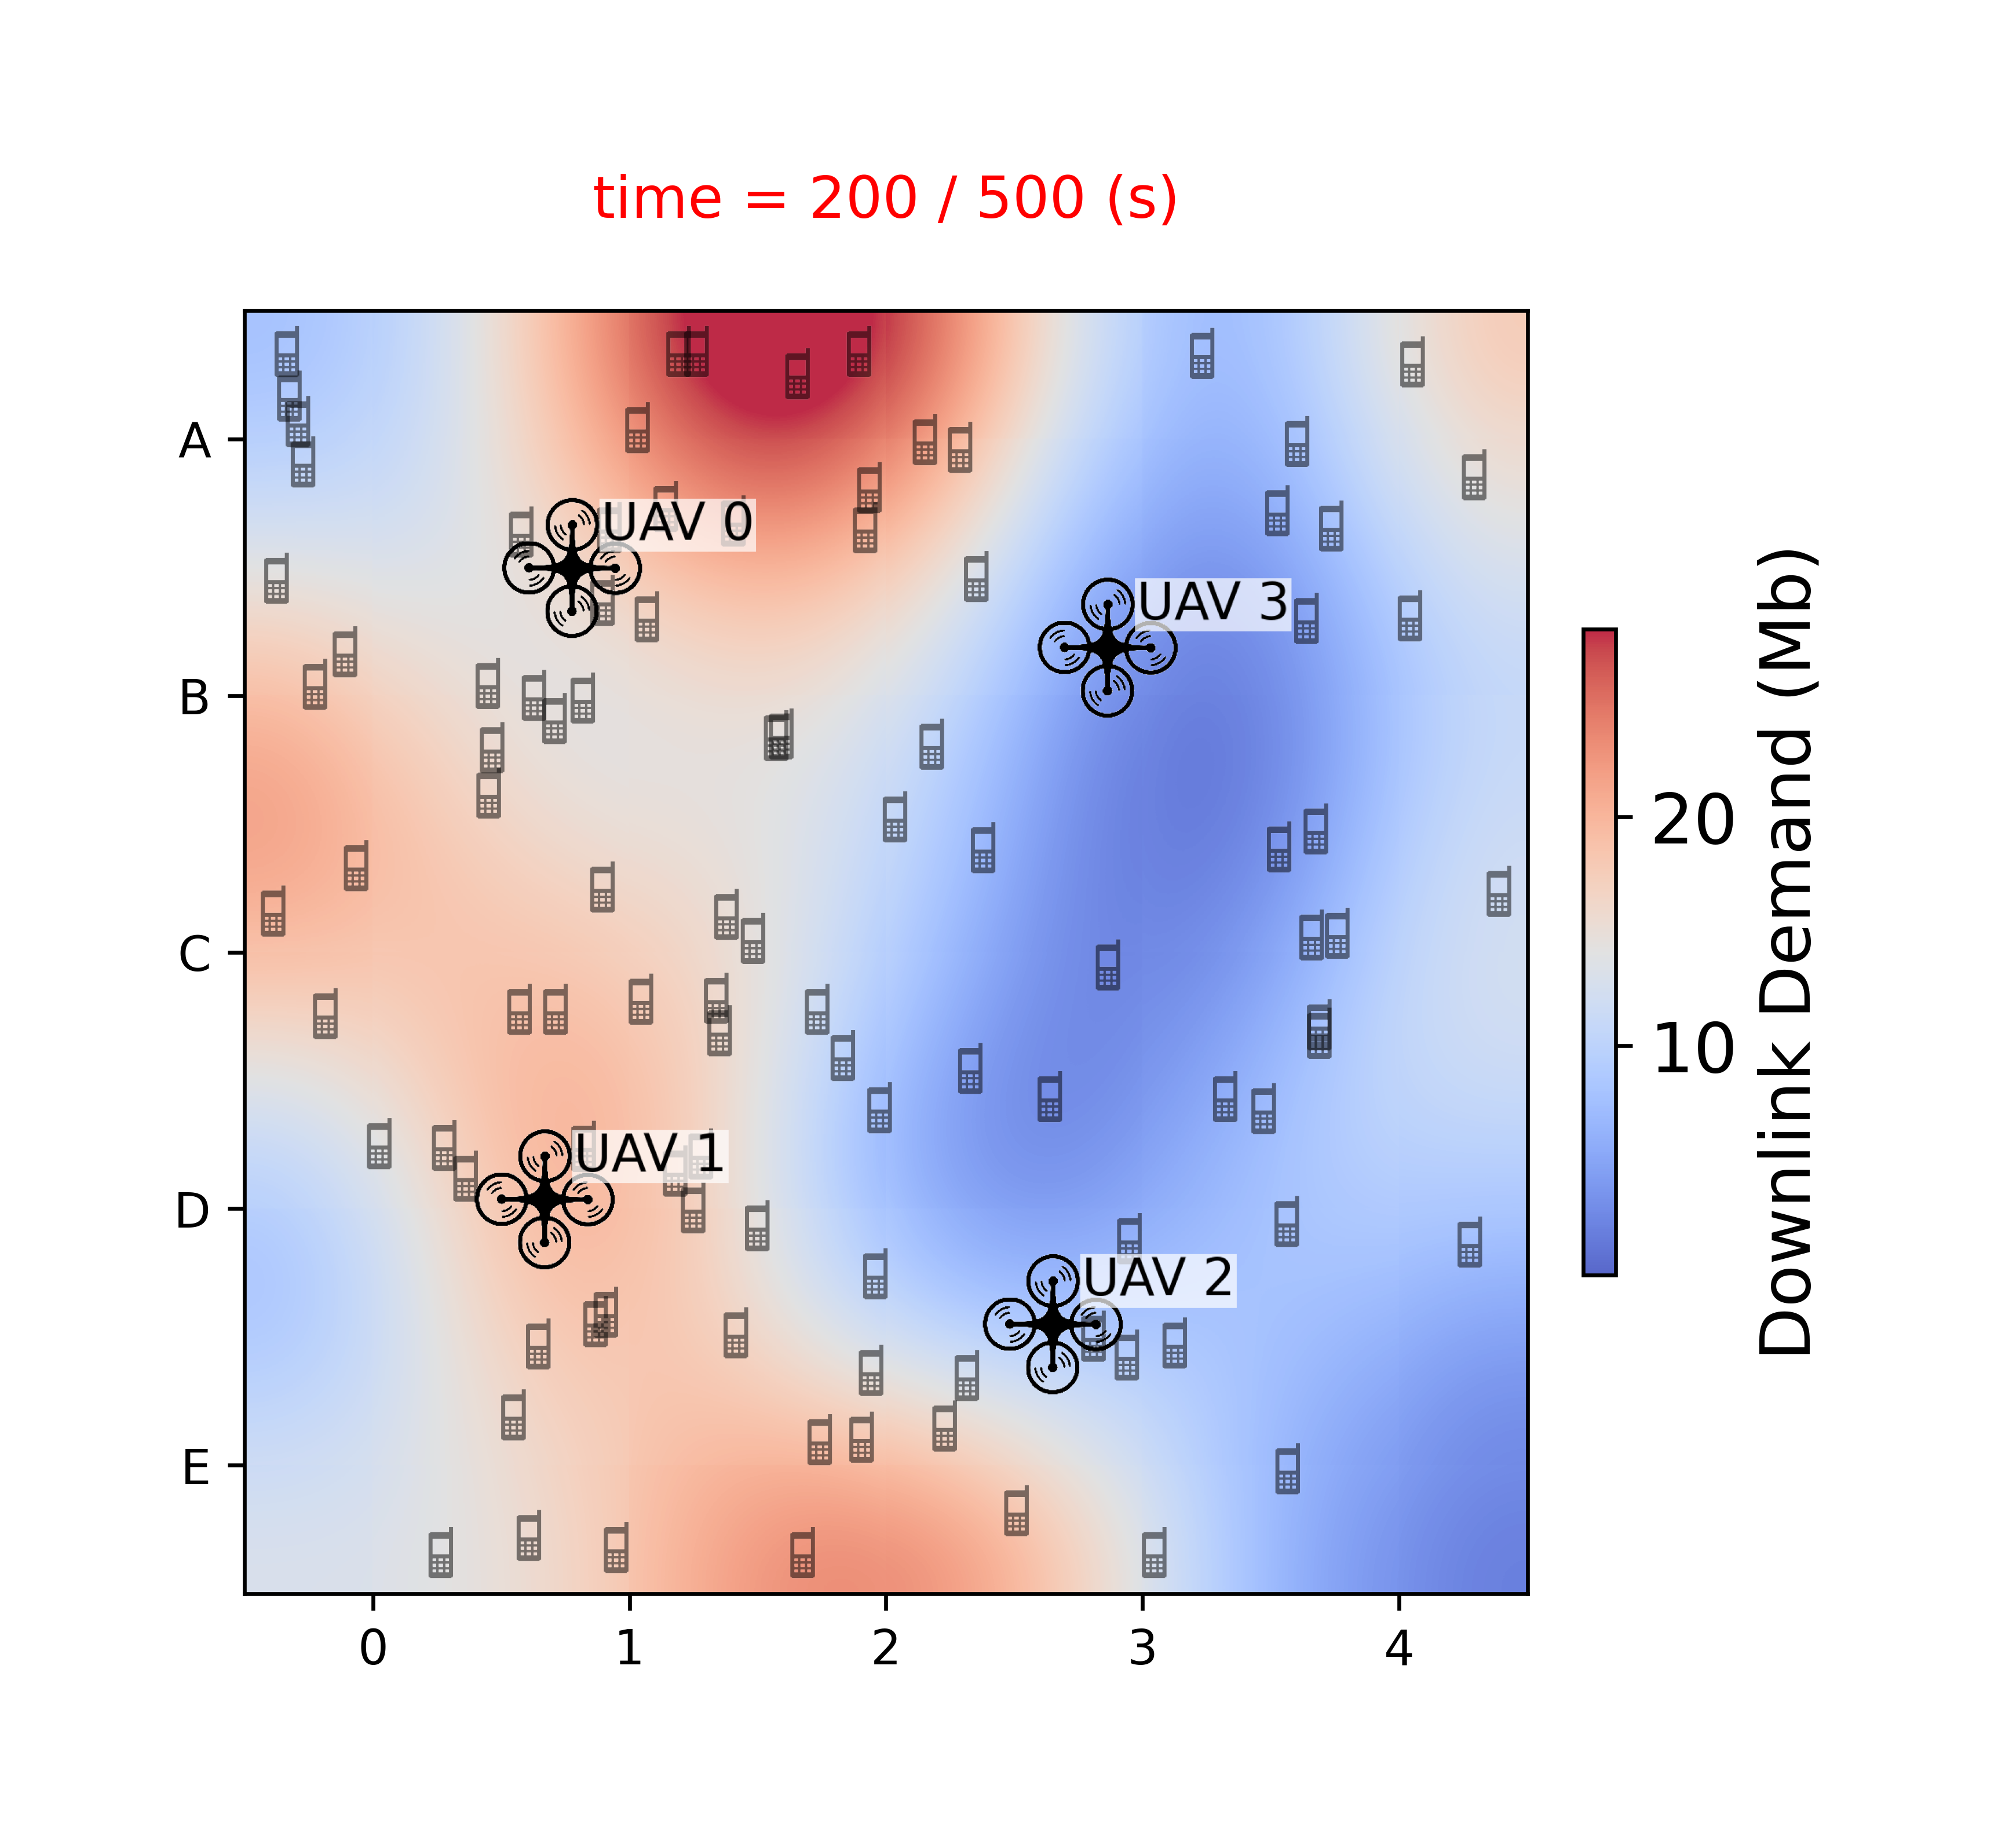

In [52]:
#
# Heatmap: Donwlink Traffic Demand
#

t = 200
marker_sz = 30

n_grids2 = 5
grid_size2 = int(2*boundary/n_grids2)

users = users_proposed
uavswarm = uav_swarm_proposed

val_all = np.array([user.queue_length_Mb[t-1] for user in users]) + np.array([user.arrival_traffic_Mb[t] for user in users])
mask_active = np.array([user.active_state[t] for user in users])
norm_val = 1
fname = f'layered_heatmap_queueNtraffic_t{t}.png'

export_layered_image(uavswarm, xaxis_all, yaxis_all, t, val_all, norm_val, n_grids2, grid_size2, f'Downlink Demand (Mb)', 
                     os.path.join(sim_out_path, fname), average=False, marker_sz=marker_sz, mask_active=mask_active)
Image(filename=os.path.join(sim_out_path, fname), width=400)


### QoE Score (MOS)
NOTE: if a user is inactive, their MOS equals `np.nan` and will not be counted.

rolling interval: 1
t_step: 1


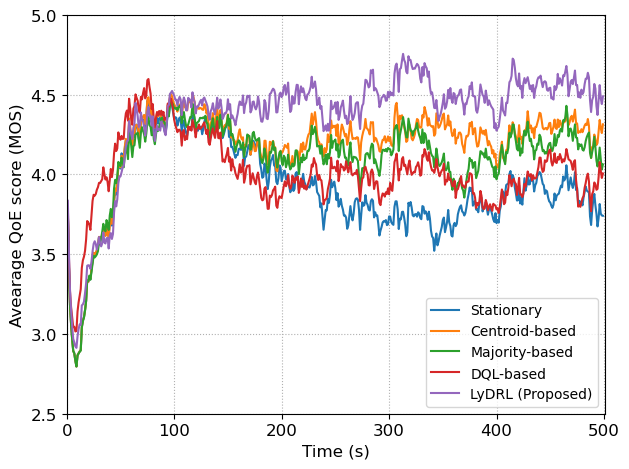

In [42]:
'''Plot the average MOS over time''' 
rolling_interval = 1  # int(ON_duration_mean_tslot)
xlim_tmin = 1           # int(t_training_start)
xlim_tmax = n_slots
t_step = 1              # for the moving average of KPI
min_period = 1

print('rolling interval:', rolling_interval)
print("t_step:", t_step)

fig, ax = plt.subplots()   
for i in range(0,len(users_list)):
    users = users_list[i]; uavs = uavs_list[i]; fname = names[i]
    mos_all = np.array([user.mos[xlim_tmin:] for user in users])        # shape=(n_users,n_slots)
    kpi_mmean = export_moving_average(
        np.nanmean(mos_all, axis=0),
        rolling_intv=rolling_interval,
        min_periods=min_period
    )
    plt.plot(
        tvec[min_period:-1:t_step] - min_period + 1,
        kpi_mmean[min_period::t_step],
        '-', label=fname, color=colors[i]
    )
    # plt.plot(tvec[xlim_tmin::t_step], kpi_mmean[::t_step], linestyle='--', label=fname+f' (movavg={rolling_interval})', color=colors[i])
    
plt.xlabel('Time (s)', fontsize='large')
plt.ylabel('Avearage QoE score (MOS)', fontsize='large')
plt.ylim(bottom=2.5, top=5)
plt.xlim(left=0, right=xlim_tmax)
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(fontsize='medium', loc='lower right', fancybox=True)
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(os.path.join(sim_out_path, 'qoe.pdf'), bbox_inches='tight')
plt.show()


In [43]:
#
# Export MOS of all users over time
#

users_ = users_list
names_ = names
for id in range(len(users_)):
    for i in range(0,len(users_list)):
        mos_all = np.array([user.mos for user in users_[id]])        # shape=(n_users,n_slots)
        
    df_mos = pd.DataFrame(mos_all)               
    df_mos.to_excel(os.path.join(sim_out_path, f'mos_all_users_over_time_{names_[id]}.xlsx'))
    
print(f'Exported to {sim_out_path}')

Exported to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10


### Service Unavailability

rolling_interval: 1


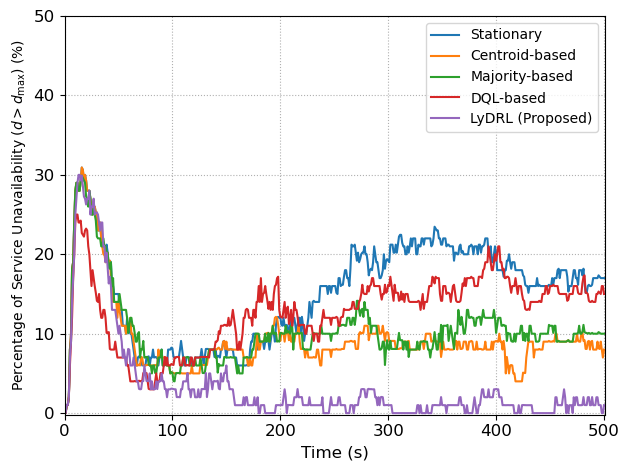

In [44]:
rolling_interval = 1
xlim_tmin = 0
mos_th = 1

print("rolling_interval:", rolling_interval)

fig, ax = plt.subplots()
for i in range(0,len(users_list)):
    users = users_list[i]
    uavs = uavs_list[i]
    fname = names[i]
    mos_all = np.array([user.mos for user in users])   # shape=(n_users,n_slots)
    kpi_mmean = export_moving_average(
        np.nansum(mos_all > mos_th, axis=0)/(n_users-np.sum(np.isnan(mos_all), axis=0)),
        rolling_intv=rolling_interval
    )
    ax = sns.lineplot(x=tvec[xlim_tmin::], y=(1 - kpi_mmean[xlim_tmin::]) * 100, label=fname)
    
plt.xlabel('Time (s)', fontsize='large')
plt.ylabel('Percentage of Service Unavailability ($d>d_{\max}$) (%)', fontsize='medium')
plt.xlim(left=xlim_tmin, right=xlim_tmax)
plt.ylim(top=50, bottom=-0.2)
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.legend(fontsize='medium', fancybox=True)
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(os.path.join(sim_out_path, 'service-unavailable.pdf'), bbox_inches='tight')
plt.show()


### QoE Fairness

rolling = 1


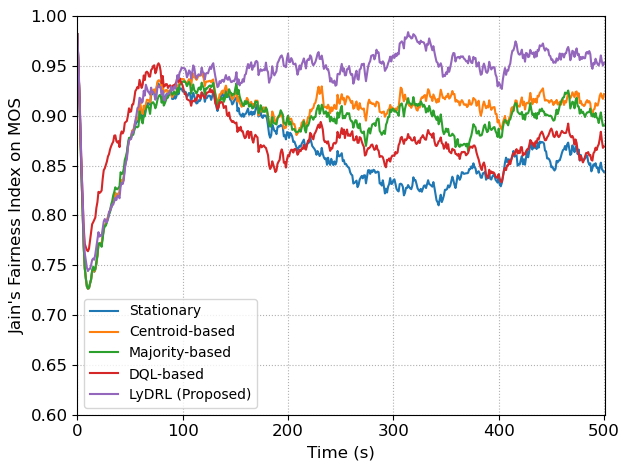

In [45]:
rolling_interval = 1
xlim_tmin = 0
xlim_tmax = n_slots
t_step = 1

print("rolling =", rolling_interval)

fig, ax = plt.subplots()   
for i in range(0,len(users_list)):
    users, uavs, fname = users_list[i], uavs_list[i], names[i]
    mos_all = np.array([user.mos[xlim_tmin:] for user in users])        # shape=(n_users, n_slots)
    kpi = qoe_jain_fairness(mos_all, axis=0)     # shape=(n_slots)
    kpi_mavg = export_moving_average(kpi, rolling_intv=rolling_interval)
    plt.plot(
        tvec[::t_step], kpi_mavg[::t_step],
        '-', markerfacecolor="None",
        label=fname, color=colors[i],
    )
    
plt.xlabel('Time (s)', fontsize='large')
plt.ylabel("Jain's Fairness Index on MOS", fontsize='large')
plt.xlim(left=0, right=n_slots)
plt.ylim(bottom=0.6, top=1)
plt.xticks(fontsize="large")
plt.yticks(fontsize='large')
plt.legend(ncol=1, fontsize='medium', fancybox=True)
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig(os.path.join(sim_out_path, 'qoe-fairness.pdf'), bbox_inches='tight')
plt.show()

# DATA EXPORT

### Metadata

In [46]:
# Export system parameters to a text file (metadata) 
metadata={
    "num of slots": f'{int(n_slots)} (s)', 
    "num of users" : n_users, 
    "num of uavs" : n_uavs, 
    # "channel bandwidth":f'{channel_bandwidth/1e6} MHz', 
    "num of channels for one UAV": n_channels,
    "fixed bandwidth for one user" : f'{bw_per_user/1e6:.1f} MHz', 
    "pTx_downlink" : f'{pTx_downlink*1000} mW', 
    'boundary (m)': f'{2*boundary}x{2*boundary}',  
    'average moving speed of users':speed_user_avg, 
    "Arrival rate (Mbps)": lambd_Mb, 
    "ON_data_arrival_mean_Mb":ON_data_arrival_mean_Mb,
    'min session time (for MOS)': f'{ss_min} s',
    'max session time (for MOS)': f'{ss_max} s',
    "Vlya": lyapunov_param,
    "initial UAV location": init_locations_uav, 
    "z_init (m)":z_init,
    "z_min (m)":z_min, 
    "z_max (m)":z_max, 
    "uav_speedxy_max (m/s)":uav_speedxy_max,
    "uav_speedz_max (m/s)":uav_speedz_max,
    "learning rate": uav_controller.learning_rate, 
    'regularization parameter':uav_controller.regular_para, 
    "num of actions": n_decisions,
    "std_var for generating actions (exploration)": std_var_vxvyvz_explore,
    "std_var for generating actions (exploitation)": std_var_vxvyvz_exploit,
    "training interval": f'{training_interval} (s)',
    "memory size (training)": uav_controller.memory_size,
    "memory size (validation)":uav_controller.val_memory_size, 
    "batch size": uav_controller.batchSize_, 
    "min samples for training": uav_controller.min_samples_for_training, 
    "mean duration of ON state":ON_duration_mean_tslot,
    "mean duration of OFF state":OFF_duration_mean_tslot
}

In [47]:
with open(os.path.join(sim_out_path, "simulation_parameters.txt"), 'w') as f: 
    for key, value in metadata.items(): 
        f.write('%s: %s\n' % (key, value)) 

### KPI data

In [48]:
def export_kpi_over_time(users, sim_folder_path, method_name):
    active_state_all = np.array([user.active_state for user in users])          # shape=(n_users,n_slots)
    traffic_state_all = np.array([user.traffic_state for user in users])
    traffic_Mb_all = np.array([user.arrival_traffic_Mb for user in users])      # shape=(n_users,n_slots)
    qlen_Mb_all = np.array([user.queue_length_Mb for user in users])            # shape=(n_users,n_slots)
    mos_all = np.array([user.mos for user in users])                            # shape=(n_users,n_slots)
    chcapa_Mb_all = np.array([user.channel_capacity_Mb for user in users]) # shape=(n_users,n_slots)
     
    active_cnt = np.sum(active_state_all, axis=0)                       # shape=(n_users,)
    traffic_cnt = np.sum(traffic_state_all, axis=0)                     # shape=(n_users,)
    traffic_Mb_avg = np.sum(traffic_Mb_all, axis=0)/traffic_cnt         # shape=(n_users,)
    qlen_Mb_avg = np.sum(qlen_Mb_all, axis=0)/active_cnt                # shape=(n_users,)
    qlen_Mb_max = np.max(qlen_Mb_all,axis=0)                            # shape=(n_users,)
    mos_avg = np.nansum(mos_all, axis=0)/traffic_cnt                     # shape=(n_users,)
    mos_total = np.nansum(mos_all, axis=0)                              # shape=(n_users,)
    mos_percentile25 = np.nanpercentile(mos_all, q=25, axis=0)          # shape=(n_users,)
    chcapa_Mb_avg = np.mean(chcapa_Mb_all, axis=0)     # shape=(n_users,)
    mos_avg_alltime = np.mean(mos_avg[t_training_start:])
    qlen_Mb_avg_alltime = np.mean(qlen_Mb_avg[t_training_start:])
    
    kpis = {
        'active-count':active_cnt,     
        'traffic-incoming-cnt':traffic_cnt,            
        'traffic-Mb-avg (incoming)':traffic_Mb_avg,
        'qlen-Mb-avg (active)':qlen_Mb_avg,                      # average of active users 
        'qlen-Mb-max':qlen_Mb_max, 
        'mos-avg (active)':mos_avg,                              # average of active users 
        'mos-total':mos_total,
        'mos_percentile25':mos_percentile25,
        'chcapa-Mb-avg (active)':chcapa_Mb_avg,                  # average of active users 
        'mos-avg-alltime':mos_avg_alltime, 
        'qlen-Mb-avg-alltime':qlen_Mb_avg_alltime 
    }
    
    df = pd.DataFrame(kpis)
    fpath = os.path.join(sim_folder_path, f'{method_name}-kpis-over-time.xlsx')
    df.to_excel(fpath)  
    print(f'Exported {method_name} to {fpath}')  


In [49]:
export_kpi_over_time(users_stationary, sim_out_path, 'Stationary')
export_kpi_over_time(users_centroid, sim_out_path, 'Centroid')
export_kpi_over_time(users_proposed, sim_out_path, 'Proposed')

Exported Stationary to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10\Stationary-kpis-over-time.xlsx
Exported Centroid to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10\Centroid-kpis-over-time.xlsx
Exported Proposed to simulation\sim-output\test, n_slots=501, n_users=100, n_uavs=4, ld=2.0 Mbps, v_user_avg=1, vxy_uav_max=30, uOFF=1, k=10\Proposed-kpis-over-time.xlsx
